## Neural Nets Implementation & XOR Problem

**Goal:** The goal of this exercise is to implement a small neural network from scratch and train it using backprop.

In [126]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import abc
from tqdm import tqdm
from sklearn.metrics import classification_report

In [127]:
# Load xor toy dataset
with open('xordata.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train'] # 800 training data points with 2 features
y_train = data['y_train'] # training binary labels {0,1}

X_test = data['X_test']
y_test = data['y_test']

In [128]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 2) (800,)
(200, 2) (200,)


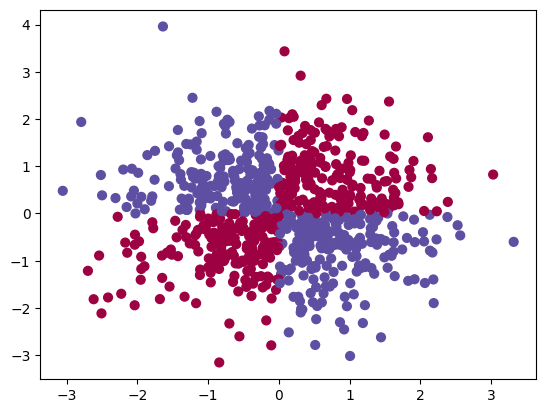

In [129]:
plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train, cmap=plt.cm.Spectral)

**In this exercise, do the following:**
1. Implement brackprop to train a two-layer perceptron: an input layer, a hidden layer, and an output layer.
2. The core of the code should include: a forward pass, a backward pass, and weight updates.
3. For input and output layers specify the number of nodes appropriate for the above problem.
4. Randomly initialize the weights and biases of the network.
5. For the hidden layer use ReLU as an activation function and for the output layer use logistic sigmoid.
6. Use cross-entropy loss as the network's loss function and mini-batch SGD as the optimizer.
7. Use cross-validation to estimate performance.
8. Tune the network as you see fit (including number of units in the hidden layer, learning rate,  batch size, number of epochs, etc).
9. Provide a classification report of the performance on the train and test set.
10. Write a summary. Make sure you document your code well.
  
(Optional) You can use sklearn.inspection.DecisionBoundaryDisplay to visualize your decision boundary.

In [130]:
def one_hot_encode(y, n_classes):
    return np.identity(n_classes)[y.astype(int)]

def generate_data(dataset_name, n_samples=100):
    match dataset_name:
        case 'regression: an affine line':
            X = np.random.uniform(-5, 5, size=(n_samples, 1))
            y = 3 * X - 100
        case 'regression: cubic polynomial':
            X = np.random.uniform(-5, 5, size=(n_samples, 1))
            y = X ** 3 - 2 * X + 5
        case 'classification: linearly separable':
            X = np.random.normal(size=(n_samples, 2))
            y = one_hot_encode((X[:, 0] > X[:, 1] + 1).astype(int), 2)
        case 'classification: XOR':
            X = np.random.normal(size=(n_samples, 2))
            y = one_hot_encode((X[:, 0] * X[:, 1] > 0).astype(int), 2)
        case _:
            raise ValueError('invalid dataset name')
    return X, y


def train_and_test(model, loss_fn, optimizer, dataset_name, n_epochs=5000, n_samples=100):
    # train
    X_train, y_train = generate_data(dataset_name, n_samples=n_samples)
    losses = []
    for _ in tqdm(range(n_epochs)):
        output = model.forward(X_train)
        loss = loss_fn.forward(output, y_train) 
        losses.append(loss)
        model.backward(loss_fn.backward())
        optimizer.step()

    # test and plot
    X_test, y_test = generate_data(dataset_name, n_samples=n_samples)
    fig, ax = plt.subplots(ncols=2)
    fig.set_size_inches(10, 5)
    ax[0].set_title('loss during training')
    ax[1].set_title('predictions and truth')
    if dataset_name.startswith('classification'):
        # really we should take a softmax here, but this works too (same answer but less interpretable)
        y_pred = np.argmax(model.forward(X_test), axis=1)
        sns.lineplot(losses, ax=ax[0])
        sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=np.argmax(y_test, axis=1), ax=ax[1])
        sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_pred, s=100, alpha=0.2, ax=ax[1])
        plt.legend([],[], frameon=False)
    elif dataset_name.startswith('regression'):
        y_pred = model.forward(X_test)
        sns.lineplot(losses, ax=ax[0])
        sns.scatterplot(x=X_test[:, 0], y=y_test[:, 0], ax=ax[1])
        sns.scatterplot(x=X_test[:, 0], y=y_pred[:, 0], s=100, alpha=0.2, ax=ax[1])
        plt.legend([],[], frameon=False)

In [131]:
class Module(abc.ABC):
    # require inheriting classes to implement the abstract methods
    __metaclass__ = abc.ABCMeta 

    def __init__(self, name):
        '''
        Stores learnable weights in a dictionary `self.weights` keyed by
        strings.
        '''
        self.name = name
        self.weights = {}
        self.grad_weights = {}

    @abc.abstractmethod
    def forward(self, input):
        '''
        Computes the output of the module, then stores the output in
        `self.output` and returns it.
        '''
        pass

    @abc.abstractmethod
    def backward(self, grad_output):
        '''
        Computes `self.grad_weights` organized as a dictionary in the same
        way as `self.weights` and returns `grad_input`.
        '''
        pass

    def __repr__(self):
        return self.name


class Composition(Module): # in PyTorch this is called `Sequential`
    
    def __init__(self, submodules):
        self.submodules = submodules
        # comma separated string of submodule names
        self.name = f'Composition({", ".join(submodule.name for submodule in submodules)})'
        self.weights = {
            f'{submodule.name}.{weight_name}': weight
            for submodule in self.submodules
            for weight_name, weight in submodule.weights.items()
        }

    def forward(self, input):
        for submodule in self.submodules:
            input = submodule.forward(input)
        self.output = input
        return input
    
    def backward(self, grad_output):
        for submodule in reversed(self.submodules):
            # the value of submodule.backward is the grad_output for the next
            # submodule
            grad_output = submodule.backward(grad_output)
        # collect all the grad_weights together
        self.grad_weights = {
            f'{submodule.name}.{weight_name}': grad_weight
            for submodule in self.submodules
            for weight_name, grad_weight in submodule.grad_weights.items()
        }
        return grad_output

    

class SGD:

    def __init__(self, module, lr=1e-3):
        self.module = module
        self.lr = lr

    def step(self):
        for weight_name, weight in self.module.weights.items():
            weight -= self.lr * self.module.grad_weights[weight_name]
    

In [132]:
class MSE(Module):

    def __init__(self):
        super().__init__('MSE')

    def forward(self, input_y, input_t):
        self.input_y = input_y
        self.input_t = input_t
        return np.mean((input_y - input_t) ** 2)
    
    def backward(self):
        return 2 * (self.input_y - self.input_t) / len(self.input_t)

In [133]:
class Linear(Module):

    def __init__(self, n_in_features, n_out_features):
        super().__init__(f'Linear({n_in_features}, {n_out_features})')
        self.n_in_features = n_in_features
        self.n_out_features = n_out_features
        
        # Initialize weights so that they are uniformly in the unit ball. Don't
        # worry about this choice; for examples of other choices, see
        # https://pytorch.org/docs/stable/nn.init.html
        stdv = 1.0 / np.sqrt(self.n_in_features)
        sample_unit_ball = lambda size: np.random.uniform(-stdv, stdv, size)
        self.weights = {
            'W': sample_unit_ball((n_out_features, n_in_features)),
            'b': sample_unit_ball((n_out_features, ))
        }

    def forward(self, input):
        self.input = input # this is our x
        return input @ self.weights['W'].T + self.weights['b']

    def backward(self, grad_output):
        self.grad_weights = {
            'W': grad_output.T @ self.input, # this second term is our gradient
            'b': grad_output.T @ np.ones((len(self.input), )) # this second term is our gradient
        }
        # return the grad_input
        grad_linear = self.weights['W']
        return grad_output @ grad_linear

100%|██████████| 100/100 [00:00<00:00, 8397.51it/s]


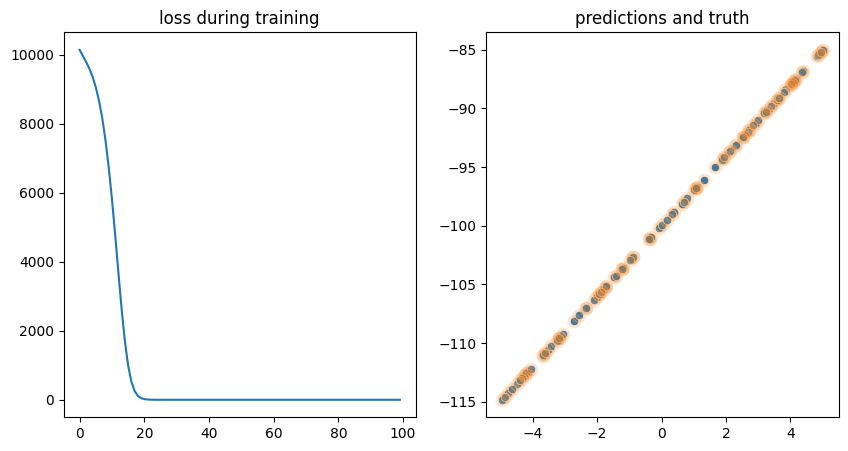

In [134]:
model = Composition([
    Linear(1, 8),
    Linear(8, 1)
])

train_and_test(
    model=model,
    loss_fn=MSE(),
    optimizer=SGD(model, lr=1e-3),
    dataset_name='regression: an affine line',
    n_epochs=100,
    n_samples=100
)

In [135]:
class Softmax(Module):

    def __init__(self, n_classes):
        super().__init__(f'Softmax({n_classes})')
        self.n_classes = n_classes

    def forward(self, input):
        p = np.exp(input)
        sums = np.sum(p, axis=1)
        self.output = (p.T / sums.T).T
        return self.output
    
    def backward(self, grad_output):
        # hacks :)
        s = self.output
        diag = np.einsum('ij, jk -> ijk', s, np.identity(s.shape[1]))
        outer = np.einsum('ij, ik -> ijk', s, s)
        grad_softmax = diag - outer
        return np.einsum('ijk, ik -> ij', grad_softmax, grad_output)
    

class ReLU(Module):

    def __init__(self):
        super().__init__('ReLU')

    def forward(self, input):
        self.input = input
        return input * (input > 0)
    
    def backward(self, grad_output):
        grad_relu = (self.input > 0)
        return grad_output * grad_relu

100%|██████████| 5000/5000 [00:00<00:00, 7440.10it/s]


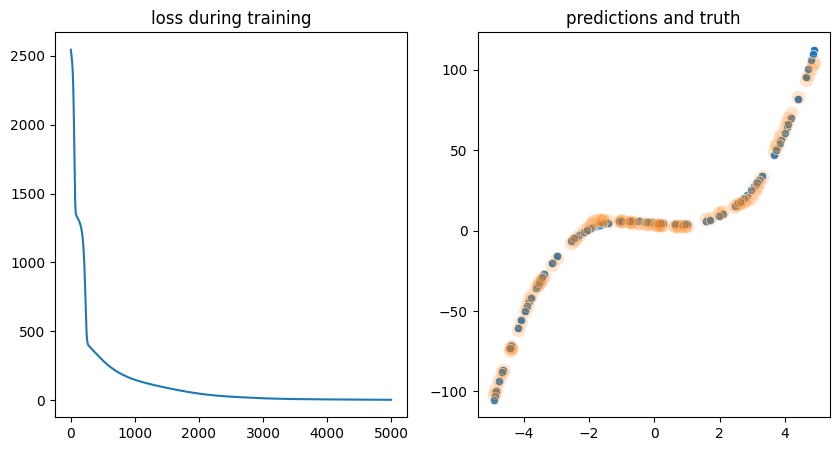

In [136]:
model = Composition([
    Linear(1, 8),
    ReLU(),
    Linear(8, 8),
    ReLU(),
    Linear(8, 1),
])

train_and_test(
    model,
    MSE(),
    SGD(model, lr=1e-4),
    'regression: cubic polynomial',
    n_epochs=5000,
    n_samples=100
)

In [137]:
class SoftmaxCrossEntropy(Module):

    def __init__(self, n_classes):
        super().__init__(f'CrossEntropy({n_classes})')
        self.n_classes = n_classes
        self.softmax = Softmax(n_classes)

    def forward(self, input, t):
        self.t = t
        self.softmax_output = self.softmax.forward(input)
        # the 1e-6 for numerical stability
        return -np.mean(t * np.log(self.softmax_output + 1e-6))
    
    def backward(self):
        # the goated identity
        return (self.softmax_output - self.t) / len(self.t)

100%|██████████| 1000/1000 [00:00<00:00, 10276.18it/s]


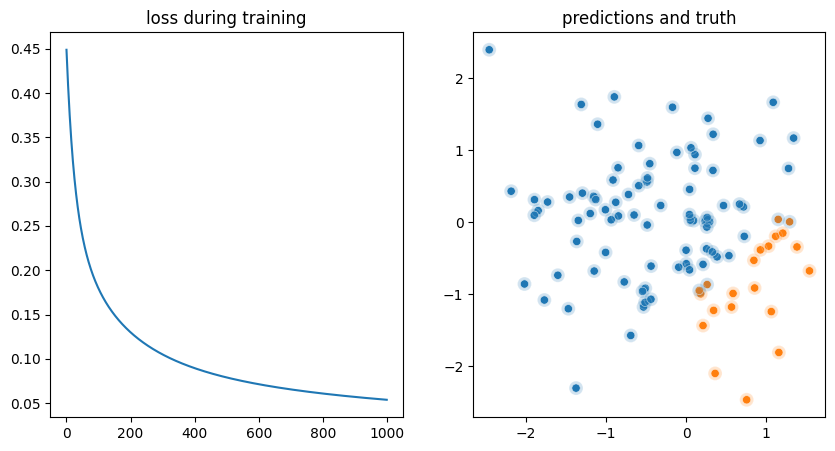

In [138]:
model = Composition([
    Linear(2, 8),
    Linear(8, 2),
    # do not apply softmax here!
])

train_and_test(
    model,
    SoftmaxCrossEntropy(2),
    SGD(model, lr=1e-2),
    'classification: linearly separable',
    n_epochs=1000,
    n_samples=100
)

100%|██████████| 5000/5000 [00:01<00:00, 2855.76it/s]


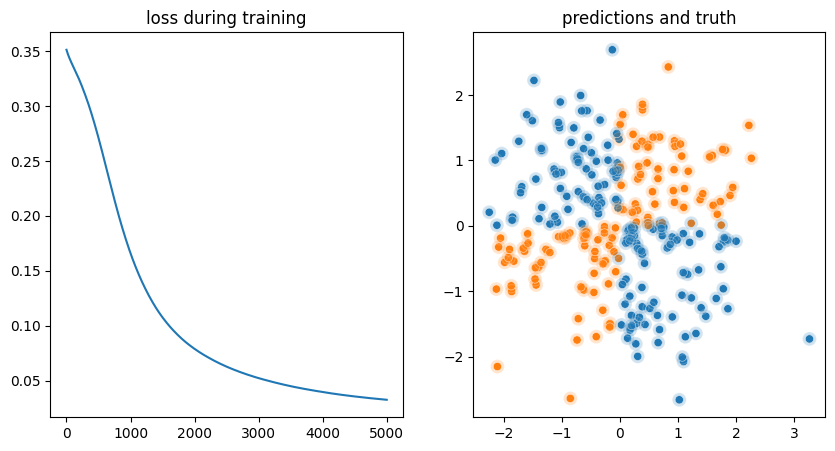

In [139]:
H = 32

model = Composition([
    Linear(2, H),
    ReLU(),
    Linear(H, H),
    ReLU(),
    Linear(H, 2)
])

train_and_test(
    model,
    SoftmaxCrossEntropy(2),
    SGD(model, lr=1e-2),
    'classification: XOR',
    n_epochs=5000,
    n_samples=250
)

**Summary**

The model trains neural network of classifiying XOR dataset with two-layer perceptron. The hidden layer spans the dimension of the input from 2 to 32 whiling using 5000 epochs and 250 samples of data. The training used Softmax, cross entropy loss and stochastic gradient with a learning rate of 0.01. From this classification task, the neural network learned non linear decision boundaries.